In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
data = pd.read_excel('E:/MyWorks/Data analyst/Data Training/Survepi.xlsx')

In [5]:
df_cholera = data[data['maladie'] == 'CHOLERA']

In [7]:
df_cholera.shape

(1316, 17)

In [9]:
df_cholera.columns

Index(['prov', 'zs', 'pop', 'numsem', 'debutsem', 'maladie', 'c1259mois',
       'd1259mois', 'c5ansp', 'd5ansp', 'casageinc', 'decageinc', 'totalcas',
       'totaldeces', 'letal', 'attaq', 'Annee'],
      dtype='object')

In [11]:
df_cholera['date'] = pd.to_datetime(df_cholera['Annee'].astype(str) + df_cholera['numsem'].astype(str).str.zfill(2) + '0', format='%Y%U%w')
df_cholera.set_index('date', inplace=True)
df_cholera = df_cholera['totalcas'].resample('M').sum()

C:\Users\Peter ciya\AppData\Local\Temp\ipykernel_8576\1315158434.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cholera['date'] = pd.to_datetime(df_cholera['Annee'].astype(str) + df_cholera['numsem'].astype(str).str.zfill(2) + '0', format='%Y%U%w')
C:\Users\Peter ciya\AppData\Local\Temp\ipykernel_8576\1315158434.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_cholera = df_cholera['totalcas'].resample('M').sum()


In [13]:
df_cholera

date
2019-01-31     734
2019-02-28     929
2019-03-31     683
2019-04-30     335
2019-05-31     329
              ... 
2024-02-29    1269
2024-03-31     490
2024-04-30     288
2024-05-31     174
2024-06-30      39
Freq: ME, Name: totalcas, Length: 66, dtype: int64

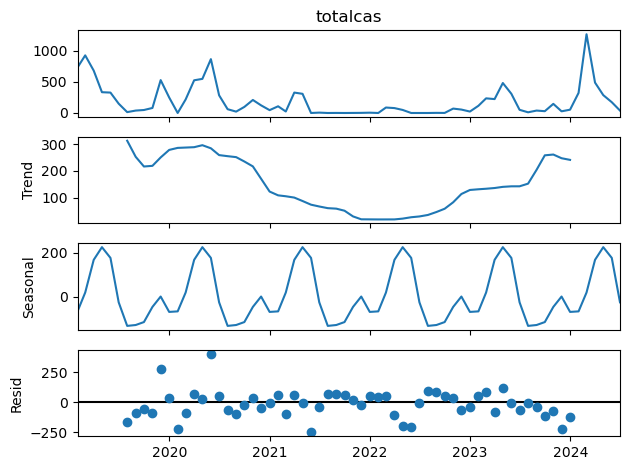

In [15]:
# Décomposition saisonnière pour vérifier les composants
decomposition = seasonal_decompose(df_cholera, model='additive', period=12)
decomposition.plot()
plt.show()

In [17]:
# Définir la validation croisée en série temporelle
tscv = TimeSeriesSplit(n_splits=5)
mse_scores = []

for train_index, test_index in tscv.split(df_cholera):
    train, test = df_cholera[train_index], df_cholera[test_index]
    
    # Ajuster le modèle SARIMA
    model = SARIMAX(train, order=(0, 1, 0), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    
    # Faire des prévisions
    forecast = model_fit.forecast(steps=len(test))
    
    
    # Calculer l'erreur quadratique moyenne (MSE)
    mse = mean_squared_error(test, forecast)
    mse_scores.append(mse)

print(forecast)
print(f'Mean Squared Error for each fold: {mse_scores}')
print(f'Average Mean Squared Error: {np.mean(mse_scores)}')

C:\Users\Peter ciya\AppData\Local\Temp\ipykernel_8576\3742068295.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train, test = df_cholera[train_index], df_cholera[test_index]
C:\Users\Peter ciya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Peter ciya\AppData\Local\Temp\ipykernel_8576\3742068295.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train, test = df_cholera[trai

2023-08-31      8.682116
2023-09-30     28.258809
2023-10-31     82.359443
2023-11-30    166.798438
2023-12-31     72.408729
2024-01-31     56.397322
2024-02-29    164.120526
2024-03-31    227.857364
2024-04-30    214.518954
2024-05-31    165.732309
2024-06-30    -37.958226
Freq: ME, Name: predicted_mean, dtype: float64
Mean Squared Error for each fold: [177571.98025554058, 155530.91312822566, 35486.32662605977, 23920.686193638703, 127045.2200605309]
Average Mean Squared Error: 103911.02525279913


In [19]:
# Définir la gamme de paramètres à tester
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

# Fonction pour trouver les meilleurs paramètres
def optimize_sarima(series, pdq, seasonal_pdq):
    best_aic = np.inf
    best_params = None
    best_seasonal_params = None
    
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = SARIMAX(df_cholera, order=param, seasonal_order=seasonal_param)
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = param
                    best_seasonal_params = seasonal_param
            except:
                continue
    return best_params, best_seasonal_params

In [21]:
# Trouver les meilleurs paramètres
best_params, best_seasonal_params = optimize_sarima(df_cholera, pdq, seasonal_pdq)
print(f'Best SARIMA parameters: {best_params}')
print(f'Best seasonal parameters: {best_seasonal_params}')
print(f'AIC: {model_fit.aic}')
print(f'BIC: {model_fit.bic}')
print(f'MSE: {model_fit.mse}')
print(f'MAE: {model_fit.mae}')
print(f'RMSE: {np.sqrt(model_fit.mse)}')

C:\Users\Peter ciya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Peter ciya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Peter ciya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\Peter ciya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for varianc

Best SARIMA parameters: (0, 0, 0)
Best seasonal parameters: (2, 0, 1, 12)
AIC: 575.3955705950859
BIC: 580.6085794499361
MSE: 64414.55537912492
MAE: 186.77412452322426
RMSE: 253.8002273031388


C:\Users\Peter ciya\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [23]:
# Ajuster le modèle SARIMA avec les meilleurs paramètres trouvés
best_params = (0, 1, 0)
model = SARIMAX(df_cholera, order=best_params, seasonal_order=best_seasonal_params)
model_fit = model.fit(disp=False)

train_data = df_cholera[:'2018-12']
test_data = df_cholera['2018-12':]

forecast0 = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
forecast1 = model_fit.forecast(steps=12)
forecast = model_fit.get_forecast(steps=12)
forecast_ci = forecast.conf_int()

In [25]:
forecast0, forecast1

(date
 2019-01-31       0.000000
 2019-02-28     734.000000
 2019-03-31     929.000000
 2019-04-30     683.000000
 2019-05-31     335.000000
                  ...     
 2024-02-29     343.667615
 2024-03-31    1264.854929
 2024-04-30     518.889621
 2024-05-31     268.777958
 2024-06-30     142.876023
 Freq: ME, Name: predicted_mean, Length: 66, dtype: float64,
 2024-07-31     34.062533
 2024-08-31     37.340345
 2024-09-30     36.261437
 2024-10-31     53.819961
 2024-11-30     38.731594
 2024-12-31     40.006675
 2025-01-31     76.623178
 2025-02-28    191.786514
 2025-03-31    101.046022
 2025-04-30     91.321047
 2025-05-31     68.849512
 2025-06-30     39.779833
 Freq: ME, Name: predicted_mean, dtype: float64)

Text(0.5, 1.0, 'SARIMA Predictions')

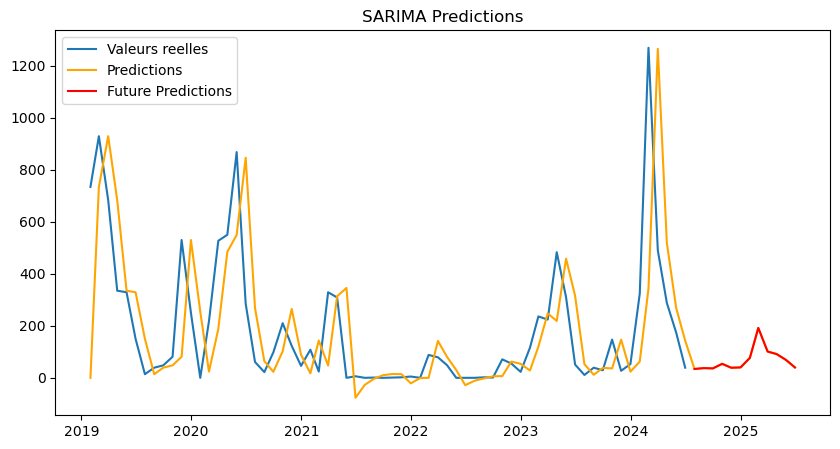

In [27]:
# Combine train, test, and forecast data
combined_data = pd.concat([train, test])
combined_forecast = pd.concat([forecast0, forecast1])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(combined_data, label='Valeurs reelles')
plt.plot(combined_forecast, label='Predictions', color='orange')
plt.plot(forecast1, label='Future Predictions', color='red')
plt.legend()
plt.title('SARIMA Predictions')

In [25]:
from flask import Flask, request, jsonify
import pickle
# Sauvegarder le modèle
with open('sarima_model.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

C:\Users\Peter ciya\AppData\Local\Temp\ipykernel_8568\2826556252.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df_cholera.index[-1], periods=12, freq='M')


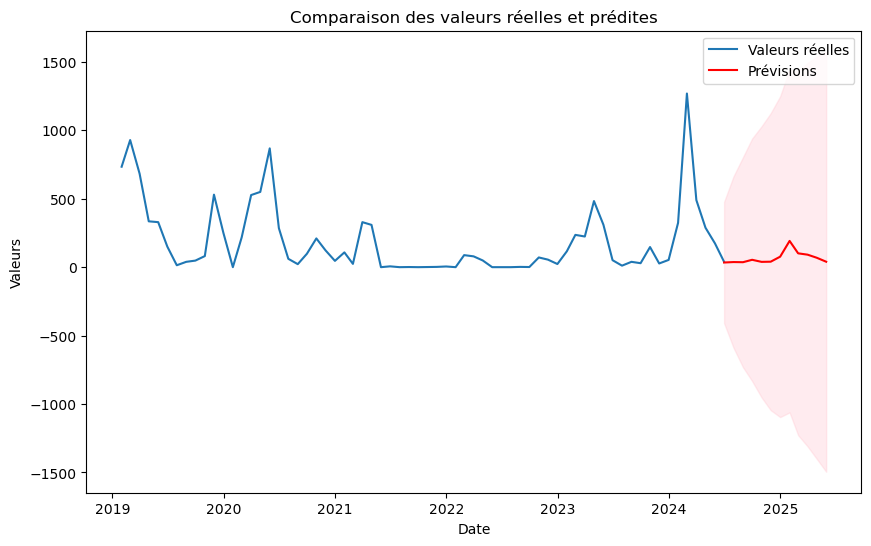

In [41]:
# Tracer les valeurs réelles
plt.figure(figsize=(10, 6))
plt.plot(df_cholera.index, df_cholera, label='Valeurs réelles')

# Tracer les prévisions
forecast_index = pd.date_range(start=df_cholera.index[-1], periods=12, freq='M')
plt.plot(forecast_index, forecast.predicted_mean, label='Prévisions', color='red')

# Tracer les intervalles de confiance
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)

# Ajouter des labels et une légende
plt.xlabel('Date')
plt.ylabel('Valeurs')
plt.title('Comparaison des valeurs réelles et prédites')
plt.legend()
plt.show()

In [115]:
from sklearn.metrics import r2_score

# Calcul du R^2
r2 = r2_score(test, forecast1)

print(f'R^2: {r2}')

R^2: -0.22551411780248665


In [117]:
print(forecast1)

2024-07-31     34.062533
2024-08-31     37.340345
2024-09-30     36.261437
2024-10-31     53.819961
2024-11-30     38.731594
2024-12-31     40.006675
2025-01-31     76.623178
2025-02-28    191.786514
2025-03-31    101.046022
2025-04-30     91.321047
2025-05-31     68.849512
Freq: ME, Name: predicted_mean, dtype: float64


In [33]:
print(forecast_ci)

            lower totalcas  upper totalcas
2024-07-31     -408.967307      477.092372
2024-08-31     -589.198462      663.879152
2024-09-30     -731.088754      803.611627
2024-10-31     -832.239717      939.879639
2024-11-30     -951.913242     1029.376431
2024-12-31    -1045.190371     1125.203722
2025-01-31    -1095.523600     1248.769956
2025-02-28    -1061.291099     1444.864128
2025-03-31    -1228.043495     1430.135539
2025-04-30    -1309.662316     1492.304409
2025-05-31    -1400.514234     1538.213259
2025-06-30    -1494.920547     1574.480214


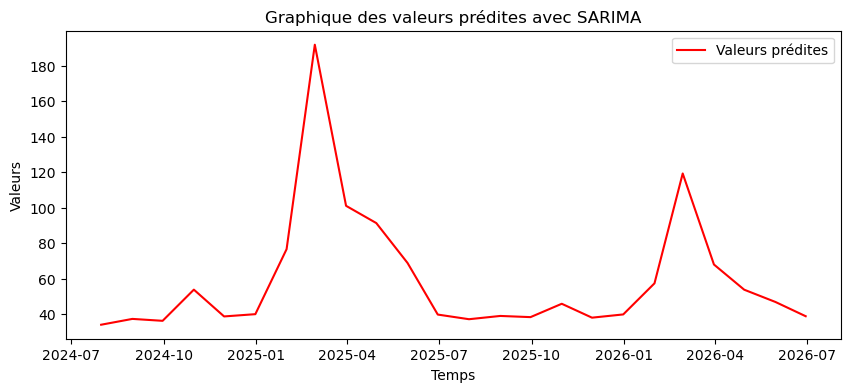

In [59]:
# Créer un graphique pour les valeurs prédites
plt.figure(figsize=(10, 4))
plt.plot(forecast1, label='Valeurs prédites', color='red')
plt.xlabel('Temps')
plt.ylabel('Valeurs')
plt.title('Graphique des valeurs prédites avec SARIMA')
plt.legend()
plt.show()

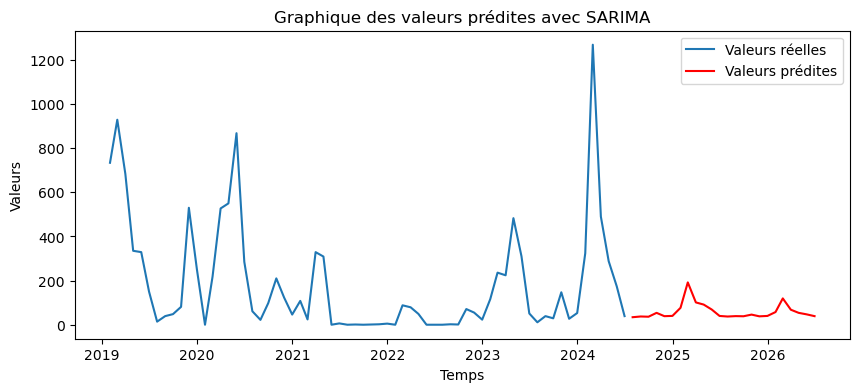

In [61]:
# Créer un graphique pour les valeurs prédites
plt.figure(figsize=(10, 4))
plt.plot(df_cholera, label='Valeurs réelles')
plt.plot(forecast1, label='Valeurs prédites', color='red')
plt.xlabel('Temps')
plt.ylabel('Valeurs')
plt.title('Graphique des valeurs prédites avec SARIMA')
plt.legend()
plt.show()

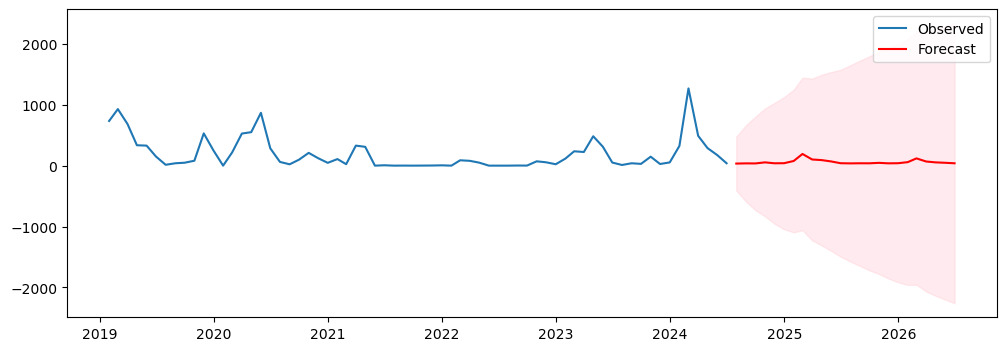

In [69]:
# Visualiser les prévisions avec intervalles de confiance
plt.figure(figsize=(12, 4))
plt.plot(df_cholera, label='Observed')
plt.plot(forecast1, label='Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.legend()
plt.show()